In [1]:
run models/samples/core/get_started/ premade_estimator.py

ERROR:root:File `'models/samples/core/get_started/.py'` not found.


In [ ]:

exec(open("./models/samples/core/get_started/premade_estimator.py").read(),globals())

In [ ]:

import sys
import os



os.environ["CUDA_VISIBLE_DEVICES"] = '0'
sys.path.append("/Users/jiadao/PycharmProjects/untitled/models/research/slim")

# From tensorflow/models/research/
#export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim

from datasets import dataset_utils
import tensorflow as tf

url = "http://download.tensorflow.org/models/vgg_16_2016_08_28.tar.gz"

# Specify where you want to download the model to
checkpoints_dir = '/Users/jiadao/PycharmProjects/untitled/checkpoints'

if not tf.gfile.Exists(checkpoints_dir):
    tf.gfile.MakeDirs(checkpoints_dir)

dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)


        

INFO:tensorflow:Restoring parameters from /Users/jiadao/PycharmProjects/untitled/checkpoints/vgg_16.ckpt


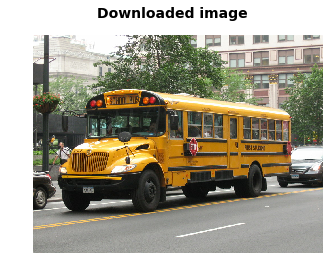

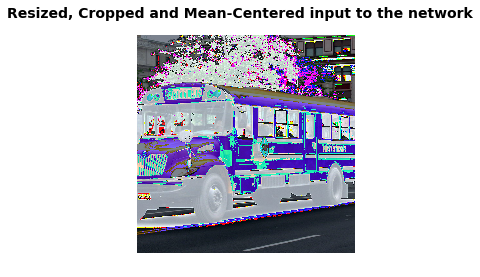

Probability 1.00 => [school bus]
Probability 0.00 => [minibus]
Probability 0.00 => [passenger car, coach, carriage]
Probability 0.00 => [trolleybus, trolley coach, trackless trolley]
Probability 0.00 => [cab, hack, taxi, taxicab]


In [22]:
%matplotlib inline

from matplotlib import pyplot as plt

import numpy as np
import os
import tensorflow as tf
from urllib.request import urlopen

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
sys.path.append("/Users/jiadao/PycharmProjects/untitled/models/research/slim")


from datasets import imagenet
from nets import vgg
from preprocessing import vgg_preprocessing

checkpoints_dir = '/Users/jiadao/PycharmProjects/untitled/checkpoints'

slim = tf.contrib.slim

# We need default size of image for a particular network.
# The network was trained on images of that size -- so we
# resize input image later in the code.
image_size = vgg.vgg_16.default_image_size


with tf.Graph().as_default():
    
    url = ("https://upload.wikimedia.org/wikipedia/commons/d/d9/"
           "First_Student_IC_school_bus_202076.jpg")
    
    # Open specified url and load image as a string
    image_string = urlopen(url).read()
    
    # Decode string into matrix with intensity values
    image = tf.image.decode_jpeg(image_string, channels=3)
    
    # Resize the input image, preserving the aspect ratio
    # and make a central crop of the resulted image.
    # The crop will be of the size of the default image size of
    # the network.
    processed_image = vgg_preprocessing.preprocess_image(image,
                                                         image_size,
                                                         image_size,
                                                         is_training=False)
    
    # Networks accept images in batches.
    # The first dimension usually represents the batch size.
    # In our case the batch size is one.
    processed_images  = tf.expand_dims(processed_image, 0)
    
    # Create the model, use the default arg scope to configure
    # the batch norm parameters. arg_scope is a very conveniet
    # feature of slim library -- you can define default
    # parameters for layers -- like stride, padding etc.
    with slim.arg_scope(vgg.vgg_arg_scope()):
        logits, _ = vgg.vgg_16(processed_images,
                               num_classes=1000,
                               is_training=False)
    
    # In order to get probabilities we apply softmax on the output.
    probabilities = tf.nn.softmax(logits)
    
    # Create a function that reads the network weights
    # from the checkpoint file that you downloaded.
    # We will run it in session later.
    init_fn = slim.assign_from_checkpoint_fn(
        os.path.join(checkpoints_dir, 'vgg_16.ckpt'),
        slim.get_model_variables('vgg_16'))
    
    with tf.Session() as sess:
        
        # Load weights
        init_fn(sess)
        
        # We want to get predictions, image as numpy matrix
        # and resized and cropped piece that is actually
        # being fed to the network.
        np_image, network_input, probabilities = sess.run([image,
                                                           processed_image,
                                                           probabilities])
        probabilities = probabilities[0, 0:]
        sorted_inds = [i[0] for i in sorted(enumerate(-probabilities),
                                            key=lambda x:x[1])]
    
    # Show the downloaded image
    plt.figure()
    plt.imshow(np_image.astype(np.uint8))
    plt.suptitle("Downloaded image", fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.show()
    
    # Show the image that is actually being fed to the network
    # The image was resized while preserving aspect ratio and then
    # cropped. After that, the mean pixel value was subtracted from
    # each pixel of that crop. We normalize the image to be between [-1, 1]
    # to show the image.
    plt.imshow( network_input / (network_input.max() - network_input.min()) )
    plt.suptitle("Resized, Cropped and Mean-Centered input to the network",
                 fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.show()

    names = imagenet.create_readable_names_for_imagenet_labels()
    for i in range(5):
        index = sorted_inds[i]
        # Now we print the top-5 predictions that the network gives us with
        # corresponding probabilities. Pay attention that the index with
        # class names is shifted by 1 -- this is because some networks
        # were trained on 1000 classes and others on 1001. VGG-16 was trained
        # on 1000 classes.
        print('Probability %0.2f => [%s]' % (probabilities[index], names[index+1]))
        
    res = slim.get_model_variables()

Instructions for updating:
Use the `axis` argument instead


INFO:tensorflow:Restoring parameters from /Users/jiadao/PycharmProjects/untitled/checkpoints/vgg_16.ckpt


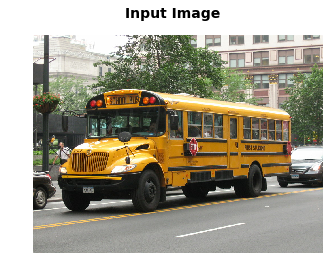

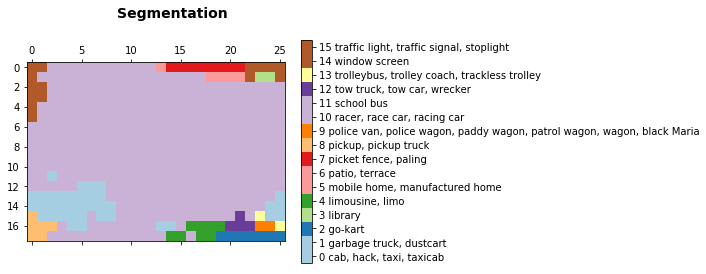

In [23]:
from preprocessing import vgg_preprocessing

# Load the mean pixel values and the function
# that performs the subtraction
from preprocessing.vgg_preprocessing import (_mean_image_subtraction,
                                            _R_MEAN, _G_MEAN, _B_MEAN)
from urllib.request import urlopen

# Function to nicely print segmentation results with
# colorbar showing class names
def discrete_matshow(data, labels_names=[], title=""):
    #get discrete colormap
    cmap = plt.get_cmap('Paired', np.max(data)-np.min(data)+1)
    # set limits .5 outside true range
    mat = plt.matshow(data,
                      cmap=cmap,
                      vmin = np.min(data)-.5,
                      vmax = np.max(data)+.5)
    #tell the colorbar to tick at integers
    cax = plt.colorbar(mat,
                       ticks=np.arange(np.min(data),np.max(data)+1))
    
    # The names to be printed aside the colorbar
    if labels_names:
        cax.ax.set_yticklabels(labels_names)
    
    if title:
        plt.suptitle(title, fontsize=14, fontweight='bold')


with tf.Graph().as_default():
    
    url = ("https://upload.wikimedia.org/wikipedia/commons/d/d9/"
           "First_Student_IC_school_bus_202076.jpg")
    
    image_string = urlopen(url).read()
    image = tf.image.decode_jpeg(image_string, channels=3)
    
    # Convert image to float32 before subtracting the
    # mean pixel value
    image_float = tf.to_float(image, name='ToFloat')
    
    # Subtract the mean pixel value from each pixel
    processed_image = _mean_image_subtraction(image_float,
                                              [_R_MEAN, _G_MEAN, _B_MEAN])

    input_image = tf.expand_dims(processed_image, 0)
    
    with slim.arg_scope(vgg.vgg_arg_scope()):
        
        # spatial_squeeze option enables to use network in a fully
        # convolutional manner
        logits, _ = vgg.vgg_16(input_image,
                               num_classes=1000,
                               is_training=False,
                               spatial_squeeze=False)
    
    # For each pixel we get predictions for each class
    # out of 1000. We need to pick the one with the highest
    # probability. To be more precise, these are not probabilities,
    # because we didn't apply softmax. But if we pick a class
    # with the highest value it will be equivalent to picking
    # the highest value after applying softmax
    pred = tf.argmax(logits, dimension=3)
    
    init_fn = slim.assign_from_checkpoint_fn(
        os.path.join(checkpoints_dir, 'vgg_16.ckpt'),
        slim.get_model_variables('vgg_16'))
    
    with tf.Session() as sess:
        init_fn(sess)
        segmentation, np_image = sess.run([pred, image])

# Remove the first empty dimension
segmentation = np.squeeze(segmentation)

# Let's get unique predicted classes (from 0 to 1000) and
# relable the original predictions so that classes are
# numerated starting from zero
unique_classes, relabeled_image = np.unique(segmentation,
                                            return_inverse=True)

segmentation_size = segmentation.shape

relabeled_image = relabeled_image.reshape(segmentation_size)

labels_names = []

for index, current_class_number in enumerate(unique_classes):

    labels_names.append(str(index) + ' ' + names[current_class_number+1])

# Show the downloaded image
plt.figure()
plt.imshow(np_image.astype(np.uint8))
plt.suptitle("Input Image", fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()

discrete_matshow(data=relabeled_image, labels_names=labels_names, title="Segmentation")

In [1]:
import numpy as np

def get_kernel_size(factor):
    """
    Find the kernel size given the desired factor of upsampling.
    """
    return 2 * factor - factor % 2


def upsample_filt(size):
    """
    Make a 2D bilinear kernel suitable for upsampling of the given (h, w) size.
    """
    factor = (size + 1) // 2
    if size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:size, :size]
    return (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)


def bilinear_upsample_weights(factor, number_of_classes):
    """
    Create weights matrix for trans

posed convolution with bilinear filter
    initialization.
    """
    
    filter_size = get_kernel_size(factor)
    
    weights = np.zeros((filter_size,
                        filter_size,
                        number_of_classes,
                        number_of_classes), dtype=np.float32)
    
    upsample_kernel = upsample_filt(filter_size)
    
    for i in range(number_of_classes):
        
        weights[:, :, i, i] = upsample_kernel
    
    return weights




In [2]:
%matplotlib inline

from __future__ import division

import os
import sys
import tensorflow as tf
import skimage.io as io
import numpy as np

os.environ["CUDA_VISIBLE_DEVICES"] = '1'
sys.path.append("/Users/jiadao/PycharmProjects/untitled/models/research/slim")
checkpoints_dir = '/Users/jiadao/PycharmProjects/untitled/checkpoints'

image_filename = '/Users/jiadao/PycharmProjects/untitled/PGM/data/cat.jpg'
annotation_filename = '/Users/jiadao/PycharmProjects/untitled/PGM/data/cat_annotation.png'

image_filename_placeholder = tf.placeholder(tf.string)
annotation_filename_placeholder = tf.placeholder(tf.string)
is_training_placeholder = tf.placeholder(tf.bool)

feed_dict_to_use = {image_filename_placeholder: image_filename,
                    annotation_filename_placeholder: annotation_filename,
                    is_training_placeholder: True}

image_tensor = tf.read_file(image_filename_placeholder)
annotation_tensor = tf.read_file(annotation_filename_placeholder)

image_tensor = tf.image.decode_jpeg(image_tensor, channels=3)
annotation_tensor = tf.image.decode_png(annotation_tensor, channels=1)

# Get ones for each class instead of a number -- we need that
# for cross-entropy loss later on. Sometimes the groundtruth
# masks have values other than 1 and 0. 
class_labels_tensor = tf.equal(annotation_tensor, 1)
background_labels_tensor = tf.not_equal(annotation_tensor, 1)

# Convert the boolean values into floats -- so that
# computations in cross-entropy loss is correct
bit_mask_class = tf.to_float(class_labels_tensor)
bit_mask_background = tf.to_float(background_labels_tensor)

combined_mask = tf.concat(axis=2, values=[bit_mask_class,
                                                bit_mask_background])

# Lets reshape our input so that it becomes suitable for 
# tf.softmax_cross_entropy_with_logits with [batch_size, num_classes]
flat_labels = tf.reshape(tensor=combined_mask, shape=(-1, 2))


Instructions for updating:
Use the retry module or similar alternatives.


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



Instructions for updating:
Use the `axis` argument instead


INFO:tensorflow:Restoring parameters from /Users/jiadao/PycharmProjects/untitled/checkpoints/vgg_16.ckpt


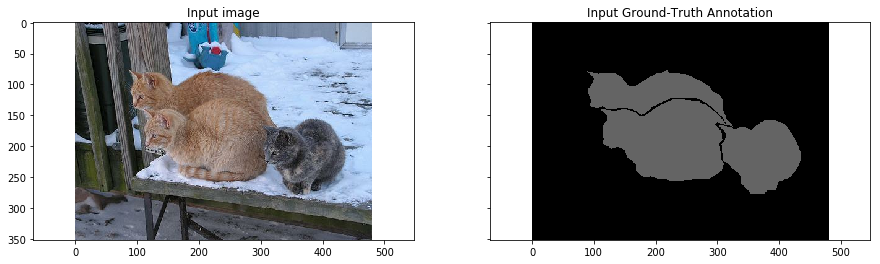

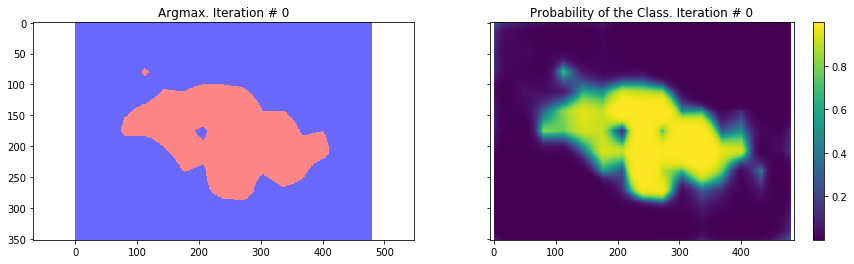

Current Loss: 163834.0


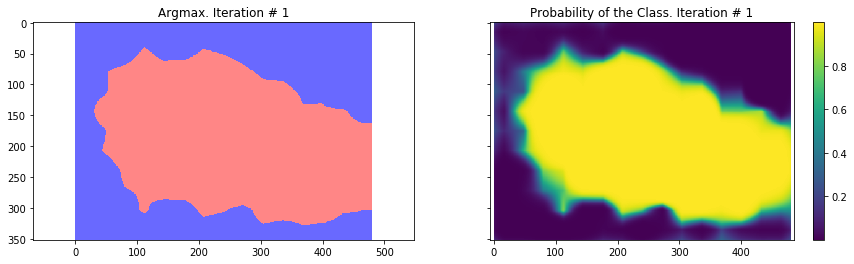

Current Loss: 41794.3


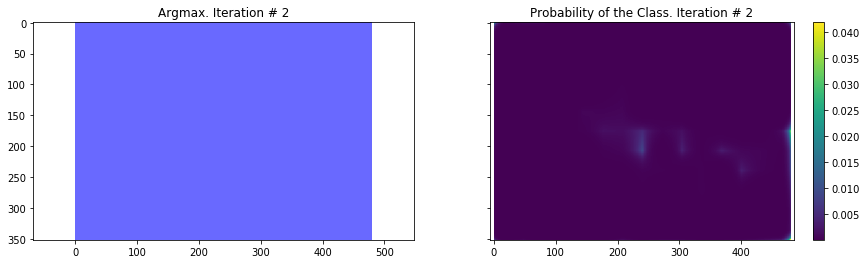

Current Loss: 350113.0


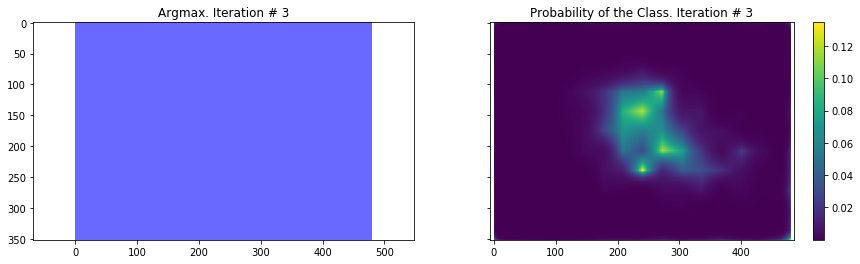

Current Loss: 344466.0


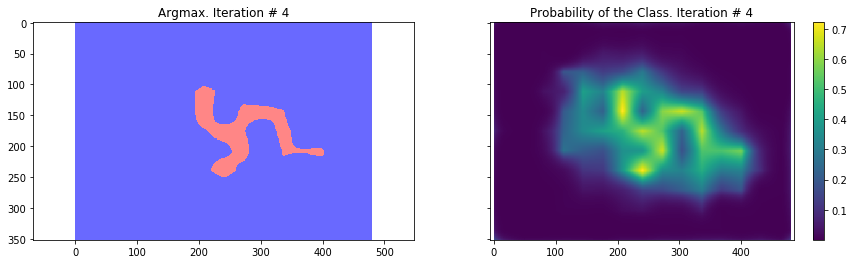

Current Loss: 179177.0


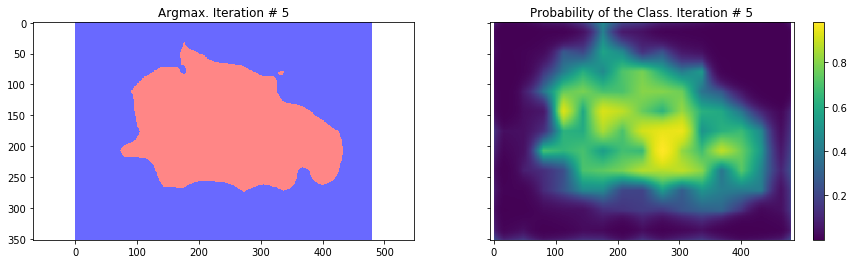

Current Loss: 55025.3


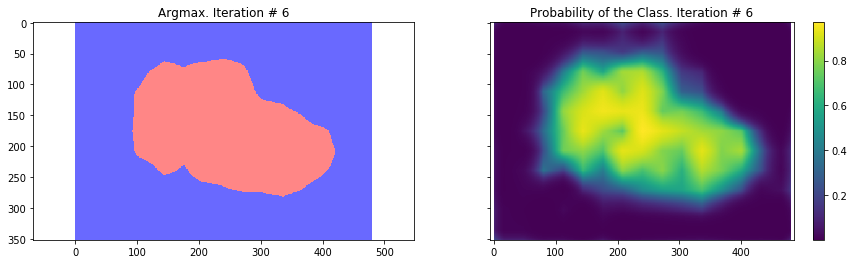

Current Loss: 49922.1


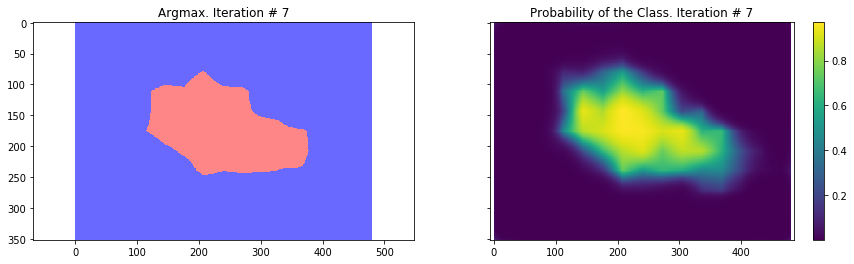

Current Loss: 34557.3


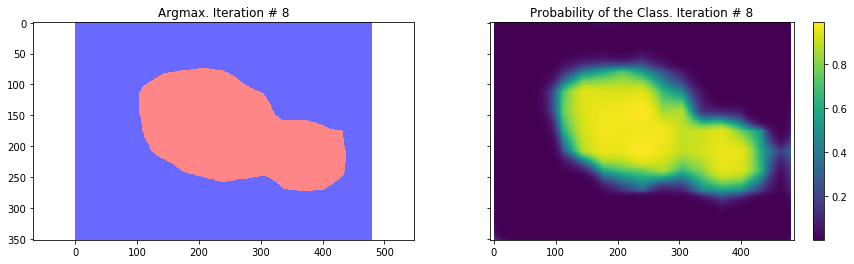

Current Loss: 36397.3


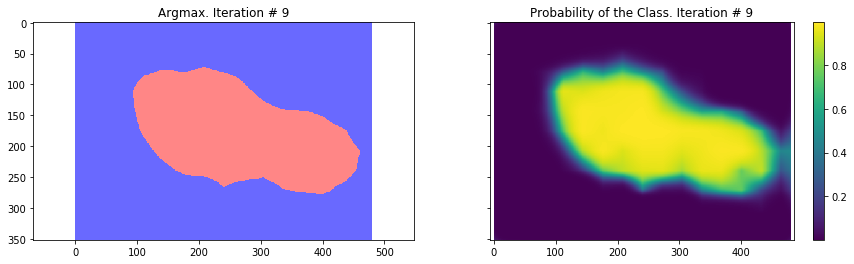

Current Loss: 22448.7


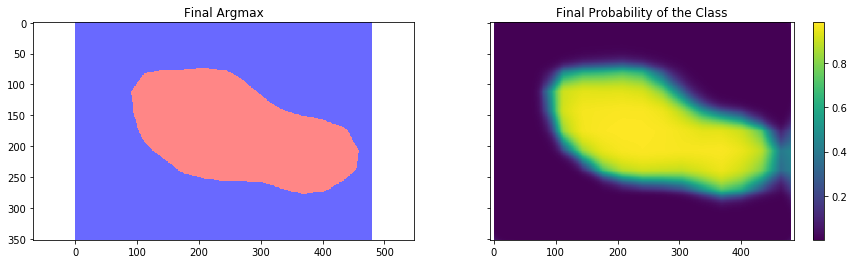

Final Loss: 24600.6


In [3]:
f = open('/Users/jiadao/PycharmProjects/untitled/PGM/data/cat.jpg', 'r')
f.name

import numpy as np
import tensorflow as tf
import sys
import os
from matplotlib import pyplot as plt

fig_size = [15, 4]
plt.rcParams["figure.figsize"] = fig_size

from urllib.request import urlopen

slim = tf.contrib.slim

from nets import vgg
from preprocessing import vgg_preprocessing

# Load the mean pixel values and the function
# that performs the subtraction from each pixel
from preprocessing.vgg_preprocessing import (_mean_image_subtraction,
                                            _R_MEAN, _G_MEAN, _B_MEAN)

upsample_factor = 32
number_of_classes = 2
log_folder = '/Users/jiadao/PycharmProjects/untitled/PGM/log_folder'

vgg_checkpoint_path = os.path.join(checkpoints_dir, 'vgg_16.ckpt')

# Convert image to float32 before subtracting the
# mean pixel value
image_float = tf.to_float(image_tensor, name='ToFloat')

# Subtract the mean pixel value from each pixel
mean_centered_image = _mean_image_subtraction(image_float,
                                          [_R_MEAN, _G_MEAN, _B_MEAN])

processed_images = tf.expand_dims(mean_centered_image, 0)

upsample_filter_np = bilinear_upsample_weights(upsample_factor,
                                               number_of_classes)

upsample_filter_tensor = tf.constant(upsample_filter_np)

# Define the model that we want to use -- specify to use only two classes at the last layer
with slim.arg_scope(vgg.vgg_arg_scope()):
    
    logits, end_points = vgg.vgg_16(processed_images,
                           num_classes=2,
                           is_training=is_training_placeholder,
                           spatial_squeeze=False,
                           fc_conv_padding='SAME')

downsampled_logits_shape = tf.shape(logits)

# Calculate the ouput size of the upsampled tensor
upsampled_logits_shape = tf.stack([
                                  downsampled_logits_shape[0],
                                  downsampled_logits_shape[1] * upsample_factor,
                                  downsampled_logits_shape[2] * upsample_factor,
                                  downsampled_logits_shape[3]
                                 ])

# Perform the upsampling
upsampled_logits = tf.nn.conv2d_transpose(logits, upsample_filter_tensor,
                                 output_shape=upsampled_logits_shape,
                                 strides=[1, upsample_factor, upsample_factor, 1])

# Flatten the predictions, so that we can compute cross-entropy for
# each pixel and get a sum of cross-entropies.
flat_logits = tf.reshape(tensor=upsampled_logits, shape=(-1, number_of_classes))

cross_entropies = tf.nn.softmax_cross_entropy_with_logits(logits=flat_logits,
                                                          labels=flat_labels)

cross_entropy_sum = tf.reduce_sum(cross_entropies)

# Tensor to get the final prediction for each pixel -- pay 
# attention that we don't need softmax in this case because
# we only need the final decision. If we also need the respective
# probabilities we will have to apply softmax.
pred = tf.argmax(upsampled_logits, dimension=3)

probabilities = tf.nn.softmax(upsampled_logits)

# Here we define an optimizer and put all the variables
# that will be created under a namespace of 'adam_vars'.
# This is done so that we can easily access them later.
# Those variables are used by adam optimizer and are not
# related to variables of the vgg model.

# We also retrieve gradient Tensors for each of our variables
# This way we can later visualize them in tensorboard.
# optimizer.compute_gradients and optimizer.apply_gradients
# is equivalent to running:
# train_step = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cross_entropy_sum)
with tf.variable_scope("adam_vars"):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
    gradients = optimizer.compute_gradients(loss=cross_entropy_sum)
    
    for grad_var_pair in gradients:
        
        current_variable = grad_var_pair[1]
        current_gradient = grad_var_pair[0]
        
        # Relace some characters from the original variable name
        # tensorboard doesn't accept ':' symbol
        gradient_name_to_save = current_variable.name.replace(":", "_")
        
        # Let's get histogram of gradients for each layer and
        # visualize them later in tensorboard
        tf.summary.histogram(gradient_name_to_save, current_gradient) 
    
    train_step = optimizer.apply_gradients(grads_and_vars=gradients)
    
# Now we define a function that will load the weights from VGG checkpoint
# into our variables when we call it. We exclude the weights from the last layer
# which is responsible for class predictions. We do this because 
# we will have different number of classes to predict and we can't
# use the old ones as an initialization.
vgg_except_fc8_weights = slim.get_variables_to_restore(exclude=['vgg_16/fc8', 'adam_vars'])

# Here we get variables that belong to the last layer of network.
# As we saw, the number of classes that VGG was originally trained on
# is different from ours -- in our case it is only 2 classes.
vgg_fc8_weights = slim.get_variables_to_restore(include=['vgg_16/fc8'])

adam_optimizer_variables = slim.get_variables_to_restore(include=['adam_vars'])

# Add summary op for the loss -- to be able to see it in
# tensorboard.
tf.summary.scalar('cross_entropy_loss', cross_entropy_sum)

# Put all summary ops into one op. Produces string when
# you run it.
merged_summary_op = tf.summary.merge_all()

# Create the summary writer -- to write all the logs
# into a specified file. This file can be later read
# by tensorboard.
summary_string_writer = tf.summary.FileWriter(log_folder)

# Create the log folder if doesn't exist yet
if not os.path.exists(log_folder):
    os.makedirs(log_folder)

# Create an OP that performs the initialization of
# values of variables to the values from VGG.
read_vgg_weights_except_fc8_func = slim.assign_from_checkpoint_fn(
                                   vgg_checkpoint_path,
                                   vgg_except_fc8_weights)

# Initializer for new fc8 weights -- for two classes.
vgg_fc8_weights_initializer = tf.variables_initializer(vgg_fc8_weights)

# Initializer for adam variables
optimization_variables_initializer = tf.variables_initializer(adam_optimizer_variables)

with tf.Session() as sess:
    
    # Run the initializers.
    read_vgg_weights_except_fc8_func(sess)
    sess.run(vgg_fc8_weights_initializer)
    sess.run(optimization_variables_initializer)
    
    train_image, train_annotation = sess.run([image_tensor, annotation_tensor],
                                              feed_dict=feed_dict_to_use)
    
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.imshow(train_image)
    ax1.set_title('Input image')
    probability_graph = ax2.imshow(np.dstack((train_annotation,)*3)*100)
    ax2.set_title('Input Ground-Truth Annotation')
    plt.show()
    
    # Let's perform 10 interations
    for i in range(10):
        
        loss, summary_string = sess.run([cross_entropy_sum, merged_summary_op],
                                        feed_dict=feed_dict_to_use)
        
        sess.run(train_step, feed_dict=feed_dict_to_use)
        
        pred_np, probabilities_np = sess.run([pred, probabilities],
                                              feed_dict=feed_dict_to_use)
        
        summary_string_writer.add_summary(summary_string, i)
        
        cmap = plt.get_cmap('bwr')
        
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
        ax1.imshow(np.uint8(pred_np.squeeze() != 1), vmax=1.5, vmin=-0.4, cmap=cmap)
        ax1.set_title('Argmax. Iteration # ' + str(i))
        probability_graph = ax2.imshow(probabilities_np.squeeze()[:, :, 0])
        ax2.set_title('Probability of the Class. Iteration # ' + str(i))
        
        plt.colorbar(probability_graph)
        plt.show()
        
        print("Current Loss: " +  str(loss))
    
    feed_dict_to_use[is_training_placeholder] = False
    
    final_predictions, final_probabilities, final_loss = sess.run([pred,
                                                                   probabilities,
                                                                   cross_entropy_sum],
                                                         feed_dict=feed_dict_to_use)
    
    
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    
    ax1.imshow(np.uint8(final_predictions.squeeze() != 1),
               vmax=1.5,
               vmin=-0.4,
               cmap=cmap)
    
    ax1.set_title('Final Argmax')
    
    
    probability_graph = ax2.imshow(final_probabilities.squeeze()[:, :, 0])
    ax2.set_title('Final Probability of the Class')
    plt.colorbar(probability_graph)
    
    plt.show()
    
    print("Final Loss: " +  str(final_loss))
    
    
    

summary_string_writer.close()


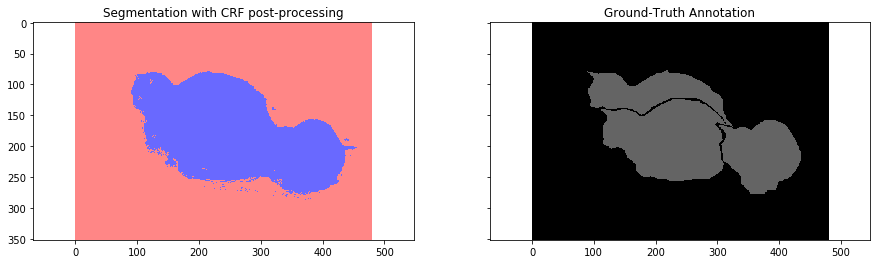

In [ ]:
import sys

path = '/Users/jiadao/PycharmProjects/untitled/dense_crf_python/'
sys.path.append(path)

import pydensecrf.densecrf as dcrf

from pydensecrf.utils import compute_unary, create_pairwise_bilateral, \
    create_pairwise_gaussian, softmax_to_unary

import skimage.io as io

image = train_image

softmax = final_probabilities.squeeze()

softmax = softmax.transpose((2, 0, 1))

# The input should be the negative of the logarithm of probability values
# Look up the definition of the softmax_to_unary for more information
unary = softmax_to_unary(softmax)

# The inputs should be C-continious -- we are using Cython wrapper
unary = np.ascontiguousarray(unary)

d = dcrf.DenseCRF(image.shape[0] * image.shape[1], 2)

d.setUnaryEnergy(unary)

# This potential penalizes small pieces of segmentation that are
# spatially isolated -- enforces more spatially consistent segmentations
feats = create_pairwise_gaussian(sdims=(10, 10), shape=image.shape[:2])

d.addPairwiseEnergy(feats, compat=3,
                    kernel=dcrf.DIAG_KERNEL,
                    normalization=dcrf.NORMALIZE_SYMMETRIC)

# This creates the color-dependent features --
# because the segmentation that we get from CNN are too coarse
# and we can use local color features to refine them
feats = create_pairwise_bilateral(sdims=(50, 50), schan=(20, 20, 20),
                                   img=image, chdim=2)

d.addPairwiseEnergy(feats, compat=10,
                     kernel=dcrf.DIAG_KERNEL,
                     normalization=dcrf.NORMALIZE_SYMMETRIC)
Q = d.inference(5)

res = np.argmax(Q, axis=0).reshape((image.shape[0], image.shape[1]))

cmap = plt.get_cmap('bwr')

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(res, vmax=1.5, vmin=-0.4, cmap=cmap)
ax1.set_title('Segmentation with CRF post-processing')
probability_graph = ax2.imshow(np.dstack((train_annotation,)*3)*100)
ax2.set_title('Ground-Truth Annotation')
plt.show()

In [1]:
import numpy as np

def get_kernel_size(factor):
    """
    Find the kernel size given the desired factor of upsampling.
    """
    return 2 * factor - factor % 2


def upsample_filt(size):
    """
    Make a 2D bilinear kernel suitable for upsampling of the given (h, w) size.
    """
    factor = (size + 1) // 2
    if size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:size, :size]
    return (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)


def bilinear_upsample_weights(factor, number_of_classes):
    """
    Create weights matrix for trans

posed convolution with bilinear filter
    initialization.
    """
    
    filter_size = get_kernel_size(factor)
    
    weights = np.zeros((filter_size,
                        filter_size,
                        number_of_classes,
                        number_of_classes), dtype=np.float32)
    
    upsample_kernel = upsample_filt(filter_size)
    
    for i in range(number_of_classes):
        
        weights[:, :, i, i] = upsample_kernel
    
    return weights




In [2]:
%matplotlib inline

from __future__ import division

import os
import sys
import tensorflow as tf
import skimage.io as io
import numpy as np

os.environ["CUDA_VISIBLE_DEVICES"] = '1'
sys.path.append("/Users/jiadao/PycharmProjects/untitled/models/research/slim")
checkpoints_dir = '/Users/jiadao/PycharmProjects/untitled/checkpoints'

image_filename = '/Users/jiadao/PycharmProjects/untitled/PGM/data/plane.jpg'
annotation_filename = '/Users/jiadao/PycharmProjects/untitled/PGM/data/plane_annotation.png'

image_filename_placeholder = tf.placeholder(tf.string)
annotation_filename_placeholder = tf.placeholder(tf.string)
is_training_placeholder = tf.placeholder(tf.bool)

feed_dict_to_use = {image_filename_placeholder: image_filename,
                    annotation_filename_placeholder: annotation_filename,
                    is_training_placeholder: True}

image_tensor = tf.read_file(image_filename_placeholder)
annotation_tensor = tf.read_file(annotation_filename_placeholder)

image_tensor = tf.image.decode_jpeg(image_tensor, channels=3)
annotation_tensor = tf.image.decode_png(annotation_tensor, channels=1)

# Get ones for each class instead of a number -- we need that
# for cross-entropy loss later on. Sometimes the groundtruth
# masks have values other than 1 and 0. 
class_labels_tensor = tf.equal(annotation_tensor, 1)
background_labels_tensor = tf.not_equal(annotation_tensor, 1)

# Convert the boolean values into floats -- so that
# computations in cross-entropy loss is correct
bit_mask_class = tf.to_float(class_labels_tensor)
bit_mask_background = tf.to_float(background_labels_tensor)

combined_mask = tf.concat(axis=2, values=[bit_mask_class,
                                                bit_mask_background])

# Lets reshape our input so that it becomes suitable for 
# tf.softmax_cross_entropy_with_logits with [batch_size, num_classes]
flat_labels = tf.reshape(tensor=combined_mask, shape=(-1, 2))


Instructions for updating:
Use the retry module or similar alternatives.


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



Instructions for updating:
Use the `axis` argument instead


INFO:tensorflow:Restoring parameters from /Users/jiadao/PycharmProjects/untitled/checkpoints/vgg_16.ckpt


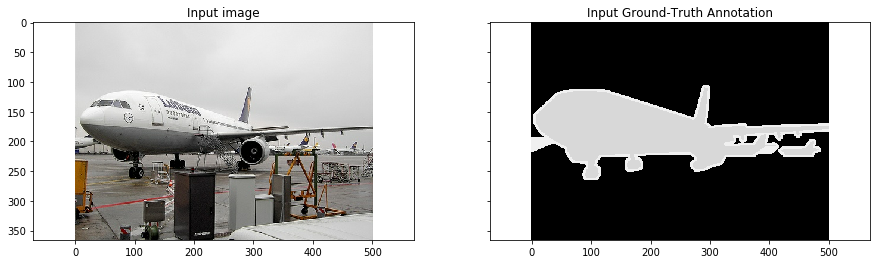

InvalidArgumentError: logits and labels must be same size: logits_size=[168960,2] labels_size=[183000,2]
	 [[Node: softmax_cross_entropy_with_logits_sg = SoftmaxCrossEntropyWithLogits[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](softmax_cross_entropy_with_logits_sg/Reshape, softmax_cross_entropy_with_logits_sg/Reshape_1)]]

Caused by op 'softmax_cross_entropy_with_logits_sg', defined at:
  File "/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/jiadao/Library/Python/3.6/lib/python/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/Users/jiadao/Library/Python/3.6/lib/python/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/jiadao/Library/Python/3.6/lib/python/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/jiadao/Library/Python/3.6/lib/python/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/jiadao/Library/Python/3.6/lib/python/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/jiadao/Library/Python/3.6/lib/python/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/jiadao/Library/Python/3.6/lib/python/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/jiadao/Library/Python/3.6/lib/python/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-7ee8739b5973>", line 75, in <module>
    labels=flat_labels)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 250, in new_func
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 1961, in softmax_cross_entropy_with_logits
    labels=labels, logits=logits, dim=dim, name=name)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 1875, in softmax_cross_entropy_with_logits_v2
    precise_logits, labels, name=name)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 7142, in softmax_cross_entropy_with_logits
    name=name)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3290, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1654, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): logits and labels must be same size: logits_size=[168960,2] labels_size=[183000,2]
	 [[Node: softmax_cross_entropy_with_logits_sg = SoftmaxCrossEntropyWithLogits[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](softmax_cross_entropy_with_logits_sg/Reshape, softmax_cross_entropy_with_logits_sg/Reshape_1)]]


In [3]:
f = open('/Users/jiadao/PycharmProjects/untitled/PGM/data/plane.jpg', 'r')
f.name

import numpy as np
import tensorflow as tf
import sys
import os
from matplotlib import pyplot as plt

fig_size = [15, 4]
plt.rcParams["figure.figsize"] = fig_size

from urllib.request import urlopen

slim = tf.contrib.slim

from nets import vgg
from preprocessing import vgg_preprocessing

# Load the mean pixel values and the function
# that performs the subtraction from each pixel
from preprocessing.vgg_preprocessing import (_mean_image_subtraction,
                                            _R_MEAN, _G_MEAN, _B_MEAN)

upsample_factor = 32
number_of_classes = 2
log_folder = '/Users/jiadao/PycharmProjects/untitled/PGM/log_folder'

vgg_checkpoint_path = os.path.join(checkpoints_dir, 'vgg_16.ckpt')

# Convert image to float32 before subtracting the
# mean pixel value
image_float = tf.to_float(image_tensor, name='ToFloat')

# Subtract the mean pixel value from each pixel
mean_centered_image = _mean_image_subtraction(image_float,
                                          [_R_MEAN, _G_MEAN, _B_MEAN])

processed_images = tf.expand_dims(mean_centered_image, 0)

upsample_filter_np = bilinear_upsample_weights(upsample_factor,
                                               number_of_classes)

upsample_filter_tensor = tf.constant(upsample_filter_np)

# Define the model that we want to use -- specify to use only two classes at the last layer
with slim.arg_scope(vgg.vgg_arg_scope()):
    
    logits, end_points = vgg.vgg_16(processed_images,
                           num_classes=2,
                           is_training=is_training_placeholder,
                           spatial_squeeze=False,
                           fc_conv_padding='SAME')

downsampled_logits_shape = tf.shape(logits)

# Calculate the ouput size of the upsampled tensor
upsampled_logits_shape = tf.stack([
                                  downsampled_logits_shape[0],
                                  downsampled_logits_shape[1] * upsample_factor,
                                  downsampled_logits_shape[2] * upsample_factor,
                                  downsampled_logits_shape[3]
                                 ])

# Perform the upsampling
upsampled_logits = tf.nn.conv2d_transpose(logits, upsample_filter_tensor,
                                 output_shape=upsampled_logits_shape,
                                 strides=[1, upsample_factor, upsample_factor, 1])

# Flatten the predictions, so that we can compute cross-entropy for
# each pixel and get a sum of cross-entropies.
flat_logits = tf.reshape(tensor=upsampled_logits, shape=(-1, number_of_classes))

cross_entropies = tf.nn.softmax_cross_entropy_with_logits(logits=flat_logits,
                                                          labels=flat_labels)

cross_entropy_sum = tf.reduce_sum(cross_entropies)

# Tensor to get the final prediction for each pixel -- pay 
# attention that we don't need softmax in this case because
# we only need the final decision. If we also need the respective
# probabilities we will have to apply softmax.
pred = tf.argmax(upsampled_logits, dimension=3)

probabilities = tf.nn.softmax(upsampled_logits)

# Here we define an optimizer and put all the variables
# that will be created under a namespace of 'adam_vars'.
# This is done so that we can easily access them later.
# Those variables are used by adam optimizer and are not
# related to variables of the vgg model.

# We also retrieve gradient Tensors for each of our variables
# This way we can later visualize them in tensorboard.
# optimizer.compute_gradients and optimizer.apply_gradients
# is equivalent to running:
# train_step = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cross_entropy_sum)
with tf.variable_scope("adam_vars"):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
    gradients = optimizer.compute_gradients(loss=cross_entropy_sum)
    
    for grad_var_pair in gradients:
        
        current_variable = grad_var_pair[1]
        current_gradient = grad_var_pair[0]
        
        # Relace some characters from the original variable name
        # tensorboard doesn't accept ':' symbol
        gradient_name_to_save = current_variable.name.replace(":", "_")
        
        # Let's get histogram of gradients for each layer and
        # visualize them later in tensorboard
        tf.summary.histogram(gradient_name_to_save, current_gradient) 
    
    train_step = optimizer.apply_gradients(grads_and_vars=gradients)
    
# Now we define a function that will load the weights from VGG checkpoint
# into our variables when we call it. We exclude the weights from the last layer
# which is responsible for class predictions. We do this because 
# we will have different number of classes to predict and we can't
# use the old ones as an initialization.
vgg_except_fc8_weights = slim.get_variables_to_restore(exclude=['vgg_16/fc8', 'adam_vars'])

# Here we get variables that belong to the last layer of network.
# As we saw, the number of classes that VGG was originally trained on
# is different from ours -- in our case it is only 2 classes.
vgg_fc8_weights = slim.get_variables_to_restore(include=['vgg_16/fc8'])

adam_optimizer_variables = slim.get_variables_to_restore(include=['adam_vars'])

# Add summary op for the loss -- to be able to see it in
# tensorboard.
tf.summary.scalar('cross_entropy_loss', cross_entropy_sum)

# Put all summary ops into one op. Produces string when
# you run it.
merged_summary_op = tf.summary.merge_all()

# Create the summary writer -- to write all the logs
# into a specified file. This file can be later read
# by tensorboard.
summary_string_writer = tf.summary.FileWriter(log_folder)

# Create the log folder if doesn't exist yet
if not os.path.exists(log_folder):
    os.makedirs(log_folder)

# Create an OP that performs the initialization of
# values of variables to the values from VGG.
read_vgg_weights_except_fc8_func = slim.assign_from_checkpoint_fn(
                                   vgg_checkpoint_path,
                                   vgg_except_fc8_weights)

# Initializer for new fc8 weights -- for two classes.
vgg_fc8_weights_initializer = tf.variables_initializer(vgg_fc8_weights)

# Initializer for adam variables
optimization_variables_initializer = tf.variables_initializer(adam_optimizer_variables)

with tf.Session() as sess:
    
    # Run the initializers.
    read_vgg_weights_except_fc8_func(sess)
    sess.run(vgg_fc8_weights_initializer)
    sess.run(optimization_variables_initializer)
    
    train_image, train_annotation = sess.run([image_tensor, annotation_tensor],
                                              feed_dict=feed_dict_to_use)
    
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.imshow(train_image)
    ax1.set_title('Input image')
    probability_graph = ax2.imshow(np.dstack((train_annotation,)*3)*100)
    ax2.set_title('Input Ground-Truth Annotation')
    plt.show()
    
    # Let's perform 10 interations
    for i in range(10):
        
        loss, summary_string = sess.run([cross_entropy_sum, merged_summary_op],
                                        feed_dict=feed_dict_to_use)
        
        sess.run(train_step, feed_dict=feed_dict_to_use)
        
        pred_np, probabilities_np = sess.run([pred, probabilities],
                                              feed_dict=feed_dict_to_use)
        
        summary_string_writer.add_summary(summary_string, i)
        
        cmap = plt.get_cmap('bwr')
        
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
        ax1.imshow(np.uint8(pred_np.squeeze() != 1), vmax=1.5, vmin=-0.4, cmap=cmap)
        ax1.set_title('Argmax. Iteration # ' + str(i))
        probability_graph = ax2.imshow(probabilities_np.squeeze()[:, :, 0])
        ax2.set_title('Probability of the Class. Iteration # ' + str(i))
        
        plt.colorbar(probability_graph)
        plt.show()
        
        print("Current Loss: " +  str(loss))
    
    feed_dict_to_use[is_training_placeholder] = False
    
    final_predictions, final_probabilities, final_loss = sess.run([pred,
                                                                   probabilities,
                                                                   cross_entropy_sum],
                                                         feed_dict=feed_dict_to_use)
    
    
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    
    ax1.imshow(np.uint8(final_predictions.squeeze() != 1),
               vmax=1.5,
               vmin=-0.4,
               cmap=cmap)
    
    ax1.set_title('Final Argmax')
    
    
    probability_graph = ax2.imshow(final_probabilities.squeeze()[:, :, 0])
    ax2.set_title('Final Probability of the Class')
    plt.colorbar(probability_graph)
    
    plt.show()
    
    print("Final Loss: " +  str(final_loss))
    
    
    

summary_string_writer.close()


In [4]:
import sys

path = '/Users/jiadao/PycharmProjects/untitled/dense_crf_python/'
sys.path.append(path)

import pydensecrf.densecrf as dcrf

from pydensecrf.utils import compute_unary, create_pairwise_bilateral, \
    create_pairwise_gaussian, softmax_to_unary

import skimage.io as io

image = train_image

softmax = final_probabilities.squeeze()

softmax = softmax.transpose((2, 0, 1))

# The input should be the negative of the logarithm of probability values
# Look up the definition of the softmax_to_unary for more information
unary = softmax_to_unary(softmax)

# The inputs should be C-continious -- we are using Cython wrapper
unary = np.ascontiguousarray(unary)

d = dcrf.DenseCRF(image.shape[0] * image.shape[1], 2)

d.setUnaryEnergy(unary)

# This potential penalizes small pieces of segmentation that are
# spatially isolated -- enforces more spatially consistent segmentations
feats = create_pairwise_gaussian(sdims=(10, 10), shape=image.shape[:2])

d.addPairwiseEnergy(feats, compat=3,
                    kernel=dcrf.DIAG_KERNEL,
                    normalization=dcrf.NORMALIZE_SYMMETRIC)

# This creates the color-dependent features --
# because the segmentation that we get from CNN are too coarse
# and we can use local color features to refine them
feats = create_pairwise_bilateral(sdims=(50, 50), schan=(20, 20, 20),
                                   img=image, chdim=2)

d.addPairwiseEnergy(feats, compat=10,
                     kernel=dcrf.DIAG_KERNEL,
                     normalization=dcrf.NORMALIZE_SYMMETRIC)
Q = d.inference(5)

res = np.argmax(Q, axis=0).reshape((image.shape[0], image.shape[1]))

cmap = plt.get_cmap('bwr')

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(res, vmax=1.5, vmin=-0.4, cmap=cmap)
ax1.set_title('Segmentation with CRF post-processing')
probability_graph = ax2.imshow(np.dstack((train_annotation,)*3)*100)
ax2.set_title('Ground-Truth Annotation')
plt.show()

NameError: name 'final_probabilities' is not defined